<a href="https://colab.research.google.com/github/pinedance/gym-AI-NLP/blob/main/gym_word_embeddings_with_BERT_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word Embeddings with BERT

Chris McCormick이 만든 [이 코드](https://github.com/pinedance/gym-AI-NLP/blob/main/gym_word_embeddings_with_BERT.ipynb)를 Class로 만들어 개량하였다.

REF
* Chris McCormick의 Tutorial: [BERT Word Embeddings Tutorial](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/)
* [Getting Contextualized Word Embeddings with BERT](https://medium.com/@r3d_robot/getting-contextualized-word-embeddings-with-bert-20798d8b43a4)
* [3 Types of Contextualized Word Embeddings From BERT Using Transfer Learning](https://towardsdatascience.com/3-types-of-contextualized-word-embeddings-from-bert-using-transfer-learning-81fcefe3fe6d)



In [ ]:
import torch
from transformers import BertTokenizer, BertModel

import pandas as pd
import numpy as np
import nltk

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Loading the pre-trained BERT model
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True, )
# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
# Setting up the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
class qModel():

    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def prepare_text( self, text ):
        """
        Preprocesses text input in a way that BERT can interpret.
        """
        marked_text = "[CLS] " + text + " [SEP]"
        tokenized_text = tokenizer.tokenize(marked_text)
        indexed_tokens = self.tokenizer.convert_tokens_to_ids( tokenized_text )
        segments_ids = [1] * len( indexed_tokens )

        # Convert inputs to PyTorch tensors
        tokens_tensor = torch.tensor( [ indexed_tokens ] )
        segments_tensors = torch.tensor( [ segments_ids ] )

        self.text = text
        self.marked_text = marked_text
        self.tokenized_text = tokenized_text
        self.indexed_tokens = indexed_tokens
        self.segments_ids = segments_ids
        self.tokens_tensor = tokens_tensor
        self.segments_tensors = segments_tensors
        if hasattr(self, 'outputs'):
            del self.outputs

        return self

    def inference( self, text=None ):
        """
        Get embeddings from an embedding model
        """
        # Gradient calculation id disabled
        # Model is in inference mode

        if text is not None:
            self.prepare_text( text )

        if not hasattr(self, 'text'):
            raise RuntimeError('text가 준비되지 않았습니다. text 값을 입력해 주세요.')

        with torch.no_grad():
            self.outputs = self.model( self.tokens_tensor, self.segments_tensors )

        return self

    def calc_token_embeddings(self, text=None ):
        """
        Preprocesses text input in a way that BERT can interpret.
        """

        if text is not None:
            self.inference( text )

        if not hasattr(self, 'outputs'):
            raise RuntimeError('outputs이 준비되지 않았습니다. text 값을 입력해 주세요.')

        hidden_states = self.outputs.hidden_states
        # Concatenate the tensors for all layers. We use `stack` here to
        # create a new dimension in the tensor.
        token_embeddings = torch.stack(hidden_states, dim=0)
        # Remove dimension 1, the "batches".
        token_embeddings = torch.squeeze(token_embeddings, dim=1)
        # Swap dimensions 0 and 1.
        token_embeddings = token_embeddings.permute(1,0,2)
        self.token_embeddings = token_embeddings
        return self

    def calc_token_vectors(self, text=None):
        """
        Preprocesses text input in a way that BERT can interpret.
        """

        if text is not None:
            self.calc_token_embeddings( text )

        if not hasattr(self, 'token_embeddings'):
            self.calc_token_embeddings()

        # intialized list to store embeddings
        token_vecs_cat = []
        token_vecs_sum = []

        # "token_embeddings" is a [Y x 12 x 768] tensor
        # where Y is the number of tokens in the sentence
        # loop over tokens in sentence
        for token in token_embeddings:
            # "token" is a [12 x 768] tensor

            # Method1: concat last 4 layers
            cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
            token_vecs_cat.append(cat_vec)

            # Method2: sum the vectors from the last four layers
            sum_vec = torch.sum(token[-4:], dim=0)
            token_vecs_sum.append(sum_vec)

        self.token_vectors = token_vecs_cat
        self.token_vectors_sum = token_vecs_sum

        return self

    def calc_sentence_vectors(self, text=None):
        """
        Preprocesses text input in a way that BERT can interpret.
        """
        if text is not None:
            self.calc_token_vectors( text )

        if not hasattr(self, 'token_vectors'):
            raise RuntimeError('token_vectors가 준비되지 않았습니다. "calc_token_vectors" 명령을 먼저 수행하세요.')

        token_vecs = self.outputs.hidden_states[-2][0]
        # Calculate the average of all 22 token vectors.
        sentence_embedding = torch.mean(token_vecs, dim=0)
        self.sentence_vectors = sentence_embedding
        return self


    """
    Preprocesses text input in a way that BERT can interpret.
    """

    def get_outputs(self):
        """
        Preprocesses text input in a way that BERT can interpret.
        """
        if not hasattr(self, 'outputs'):
            raise RuntimeError('outputs이 준비되지 않았습니다. "inference" 명령을 먼저 수행하세요.')

        return self.outputs

    def get_hidden_states(self):
        """
        Preprocesses text input in a way that BERT can interpret.
        """
        if not hasattr(self, 'outputs'):
            raise RuntimeError('outputs이 준비되지 않았습니다. "inference" 명령을 먼저 수행하세요.')

        # outputs[2] == outputs.hidden_states
        # outputs[2][-1] == outputs.last_hidden_states
        return self.outputs.hidden_states

    def get_token_vectors(self, text=None, method="cat"):
        """
        Preprocesses text input in a way that BERT can interpret.
        """
        if text is not None:
            self.calc_sentence_vectors( text )

        if not hasattr(self, 'token_vectors'):
            raise RuntimeError('token_vectors가 준비되지 않았습니다. "calc_token_vectors" 명령을 먼저 수행하세요.')

        if method == "sum":
            return self.token_vectors_sum
        else:
            return self.token_vectors

    def get_sentence_vectors(self, text=None):
        """
        Preprocesses text input in a way that BERT can interpret.
        """
        if text is not None:
            self.calc_sentence_vectors( text )

        if not hasattr(self, 'sentence_vectors'):
            raise RuntimeError('sentence_vectors가 준비되지 않았습니다. "calc_sentence_vectors" 명령을 먼저 수행하세요.')

        return self.sentence_vectors


    """
    Preprocesses text input in a way that BERT can interpret.
    """

    def fit( self, text ):
        self.inference( text )
        return self

    def transform( self ):
        self.calc_sentence_vectors()
        return self.sentence_vectors

    def fit_transform( self, text ):
        self.calc_sentence_vectors( text )
        return self.sentence_vectors

In [ ]:
text = "After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank."
mymodel = qModel( model, tokenizer )
outputs = mymodel.prepare_text( text ).inference().get_outputs()

In [ ]:
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.4964, -0.1831, -0.5231,  ..., -0.1902,  0.3738,  0.3964],
         [-0.1323, -0.2762, -0.3495,  ..., -0.4567,  0.3786, -0.1096],
         [-0.3626, -0.4002,  0.0676,  ..., -0.3207, -0.2709, -0.3004],
         ...,
         [ 0.2961, -0.2856, -0.0382,  ..., -0.6056, -0.5163,  0.2005],
         [ 0.4878, -0.0909, -0.2358,  ..., -0.0017, -0.5945, -0.2431],
         [-0.2517, -0.3519, -0.4688,  ...,  0.2500,  0.0336, -0.2627]]]), pooler_output=tensor([[-0.6031, -0.3342, -0.7174,  0.3347,  0.5145, -0.1722,  0.4502,  0.2768,
         -0.3769, -0.9998, -0.3657,  0.7535,  0.9817, -0.0192,  0.7959, -0.3459,
         -0.1338, -0.3026,  0.1097,  0.5836,  0.5736,  0.9999,  0.1798,  0.1845,
          0.2250,  0.9109, -0.5653,  0.8616,  0.8994,  0.7423, -0.2525,  0.0394,
         -0.9894, -0.1331, -0.7763, -0.9826,  0.2223, -0.6115,  0.1941,  0.0177,
         -0.7634,  0.2312,  0.9999, -0.7000,  0.4623, -0.2202, -1.0000,  0.

In [ ]:
outputs[2] == outputs.hidden_states

True

In [ ]:
outputs[2][-1] == outputs.last_hidden_state

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])

In [ ]:
hidden_states = outputs.hidden_states

In [ ]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")

layer_i = 0
print ("Number of batches:", len(hidden_states[layer_i]))

batch_i = 0
print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))

token_i = 0
print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


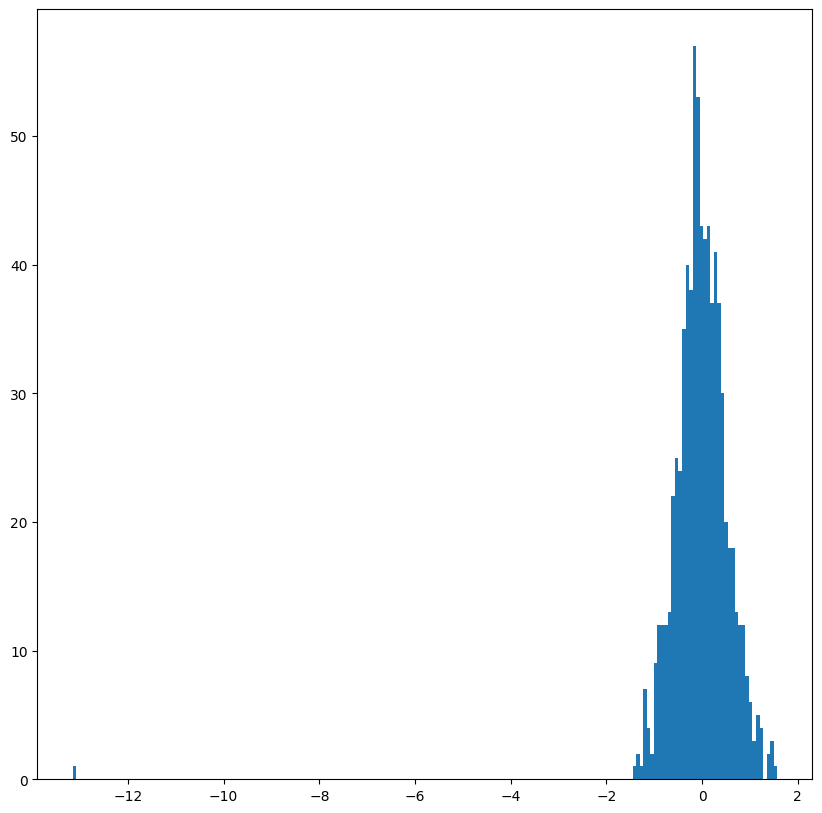

In [ ]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [ ]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)
token_embeddings.size()

torch.Size([13, 1, 22, 768])

In [ ]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)
token_embeddings.size()

torch.Size([13, 22, 768])

In [ ]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)
token_embeddings.size()

torch.Size([22, 13, 768])

In [ ]:
#  concatenate the last four layers
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)

    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 22 x 3072


In [ ]:
token_vector = token_vecs_cat

In [ ]:
for i, token_str in enumerate( mymodel.tokenized_text ) :
  print (i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


In [ ]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vector[6][:5]))
print("bank robber  ", str(token_vector[10][:5]))
print("river bank   ", str(token_vector[19][:5]))

First 5 vector values for each instance of "bank".

bank vault    tensor([ 0.9001, -0.5380, -0.1669,  0.2242,  0.6897])
bank robber   tensor([ 0.7977, -0.5217, -0.1984,  0.1890,  0.5941])
river bank    tensor([ 0.2961, -0.2856, -0.0382,  0.1674,  0.7713])


In [ ]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(token_vector[10], token_vector[19])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(token_vector[10], token_vector[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.94
Vector similarity for *different* meanings:  0.69


In [ ]:
sentences = ["bank",
	"he eventually sold the shares back to the bank at a premium.",
	"the bank strongly resisted cutting interest rates.",
	"the bank will supply and buy back foreign currency.",
	"the bank is pressing us for repayment of the loan.",
	"the bank left its lending rates unchanged.",
	"the river flowed over the bank.",
	"tall, luxuriant plants grew along the river bank.",
	"his soldiers were arrayed along the river bank.",
	"wild flowers adorned the river bank.",
	"two fox cubs romped playfully on the river bank.",
	"the jewels were kept in a bank vault.",
	"you can stow your jewellery away in the bank.",
	"most of the money was in storage in bank vaults.",
	"the diamonds are shut away in a bank vault somewhere.",
	"thieves broke into the bank vault.",
	"can I bank on your support?",
	"you can bank on him to hand you a reasonable bill for your services.",
	"don't bank on your friends to help you out of trouble.",
	"you can bank on me when you need money.",
	"i bank on your help."
]